# Model Output Notebook

<img style="float:center;" src="https://arcticexpansion.vse.gmu.edu/sites/arcticexpansion.vsnet.gmu.edu/files/images/header5d2.png" width=600px>

### ADCIRC-SWAN Output


### Initialize Libraries

In [1]:
import warnings;warnings.filterwarnings("ignore")
import netCDF4 as nc4;        import pandas as pd
import requests;              import json;
import matplotlib as mpl;     import matplotlib.pyplot as plt
import matplotlib.tri as tri; import pathlib as pl
import cartopy.crs as ccrs;   import cartopy.io.img_tiles as cart_img
import cartopy as cart;       import cartopy.io.img_tiles as cimgt
import numpy as np;           import xarray as xr
import skill_metrics as sm;   import geopandas as gpd
from shapely import Polygon,Point,MultiPoint,LineString,MultiLineString;import shapely.vectorized
from sklearn.neighbors import BallTree
from scipy.stats import linregress

source $HOME/miniforge3/bin/activate

salloc --ntasks=5 --nodes=1 --partition=normal --time=10:00:00

### Defined Functions

In [2]:
def noaa_data(begin,end,station,vdatum='NAVD',interval='6',
                       form='json',t_zone='GMT',unit='metric',product='water_level'):
    '''
    This function is used to get the data from NOAA API
    :param begin: begin date of the data
    :param end: end date of the data
    :param station: noaa station id
    :param vdatum: vertical datum such as NAVD
    :param interval: interval of the data (6 minutes)
    :param form: format of the data (json)
    :param t_zone: time zone of the data (GMT)
    :param unit: unit of the data (metric)
    :param product: type of the data (water_level)
    '''
    api = f'https://tidesandcurrents.noaa.gov/api/datagetter?begin_date={begin}&end_date={end}&station={station}'\
         f'&product={product}&application=NOS.COOPS.TAC.WL&datum={vdatum}&interval={interval}&time_zone={t_zone}&units={unit}&format={form}'
    data = requests.get(url=api).content.decode()
    return data


def nearest(items, pivot):
    return min(items, key=lambda x: abs(x - pivot))

def point_lookup(model_lat:np.array, model_lon:np.array, satellite_lat:np.array, satellite_lon:np.array):
    tree = BallTree(np.deg2rad(np.c_[model_lat,model_lon]), metric='haversine')
    distances, indices = tree.query(np.deg2rad(np.c_[satellite_lat, satellite_lon]), k = 1)
    return distances*6371,indices


#### Data for this exercise can be found here
https://doi.org/10.17603/ds2-h0fw-2p96

Download the swan_HS.63.nc from one of the 4 folders

---

### Initialize path and read netcdf file

In [3]:
root = pl.Path('/groups/ORC-CLIMATE/fhrl_repo/Arctic_Database')

#ncfile = nc4.Dataset(root / '2023' /'outputs' / 'fort.63.nc')

#### Read metadata within netcdf file

In [4]:
start = pd.to_datetime(ncfile.variables['time'].base_date)
dt = pd.date_range(start=start,freq='1h',periods=ncfile.dimensions['time'].size)

# read the lons and lats from netcdf file
x,y = ncfile.variables['x'][:],ncfile.variables['y'][:]

_____________________________________

In [4]:
stations = {'prudhoe':{'id':9497645,'lat':70.414987,'lon':-148.537066},
            'red':{'id':9491094,'lat':67.573874,'lon':-164.066624},
            'nome':{'id':9468756,'lat':64.486464,'lon':-165.450185},
            'unalakleet':{'id':9468333,'lat':63.881322,'lon':-160.820145},
            'paul':{'id':9464212,'lat':57.228635,'lon':-170.241801}}

In [ ]:
years = ['2024','2023','2022','2021','2019','2018','2017','2016']
name = 'nome'
obs_lat = stations[name]['lat']
obs_lon = stations[name]['lon']
df_list = []
for year in years:
    ncfile = nc4.Dataset(root / year /'outputs' / 'fort.63.nc')
    start = pd.to_datetime(ncfile.variables['time'].base_date)
    dt = pd.date_range(start=start,freq='1h',periods=ncfile.dimensions['time'].size)
    x,y = ncfile.variables['x'][:],ncfile.variables['y'][:]
    distances,node_ids = point_lookup(y, x,obs_lat,obs_lon)
    model = ncfile.variables['zeta'][:,node_ids[0][0]]
    df = pd.DataFrame({'dt': dt, 'data': model})
    df_daily_max = df.resample('D', on='dt').max().reset_index()
    df_daily_max["Year"] = df_daily_max["dt"].dt.year
    df_list.append(df_daily_max)
    
    #slope = np.diff(model,prepend=np.nan)
    #idm = np.where((slope[:-1] > 0) & (slope[1:] < 0))[0]


In [6]:
df_daily_wse = pd.concat(df_list, ignore_index=True)
df_annual_mean = df_daily_wse.groupby("Year")["data"].mean().reset_index()
slope, intercept, r_value, p_value, std_err = linregress(df_annual_mean["Year"], df_annual_mean["data"])
df_annual_mean["Expected_WSE"] = df_annual_mean["Year"] * slope + intercept
df_daily_wse["Year"] = df_daily_wse["dt"].dt.year
df_daily_wse["Month"] = df_daily_wse["dt"].dt.month


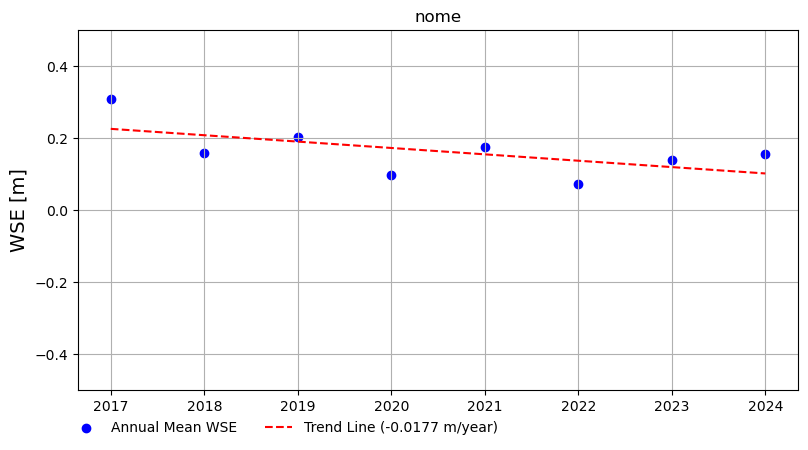

In [7]:
# plot parameters to initialize the plot
#plt.rcParams["font.family"] = "Times New Roman"
fig = plt.figure(figsize=(8,4))
colors = ['#00cc99','#ffcc66','#99cc00']
ax = plt.axes([0,0.,0.9,.9])
c=0

ax.scatter(df_annual_mean["Year"], df_annual_mean["data"], label="Annual Mean WSE", color="blue")
ax.plot(df_annual_mean["Year"], df_annual_mean["Expected_WSE"], color="red", linestyle="--", label=f"Trend Line ({slope:.4f} m/year)")



ax.set_ylabel(r'WSE [m]',fontsize=14)
ax.set_ylim([-0.50001,0.500001])

ax.grid(True)
ax.legend(loc='upper right', bbox_to_anchor=(0.6, -.05),ncol=2,frameon=False,fontsize=10)
ax.set_title(name)
ax.xaxis.set_major_locator(plt.MaxNLocator(8))
#plt.savefig(f'/Users/tmiesse/work/FHRL/arctic/model/arctic_ocean_coastal_study/figures/{name}_wl.png',dpi=480,bbox_inches='tight',pad_inches=0.1,transparent=True)
plt.show()